In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm  # for notebooks
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
load_icp = True

if load_icp:
    df_long = pd.read_csv("data/Datenbank_icp.csv")
else:
    df_long = pd.read_csv("data/Datenbank_Werte.csv")
    
    # add type to Maßnahme
    df_long["Maßnahme"] += "_" + df_long["ID"]
    df_long = df_long.drop(columns="ID")
    
    # remove patients without ICP measurement
    # drop from 220M measuremnts to 130M
    df_long = df_long.groupby("Pat_ID").filter(lambda group: any(group["Maßnahme"] == "ICP_Vital"))
    
    # drop measurements where we have a "NAN"
    df_long = df_long.dropna(subset=["Wert"])

    df_long.to_csv("data/Datenbank_icp.csv", index=False)
print("Data loaded!")

/home/anton/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Data loaded!


In [3]:
print("Columns: ", list(df_long.columns))
print(df_long.head())
print(df_long.shape)
#print(df_long["Maßnahme"].unique())
#print(df_long["Maßnahme_norm"].unique())

Columns:  ['Unnamed: 0', 'Pat_ID', 'Maßnahme', 'Maßnahme_norm', 'rel_time', 'Wert', 'DB']
   Unnamed: 0     Pat_ID Maßnahme Maßnahme_norm  rel_time  Wert   DB
0           1  474097135   Ca_BGA            Ca     419.0  1.23  UKE
1           2  474097135   Ca_BGA            Ca     492.0  1.28  UKE
2           3  474097135   Ca_BGA            Ca     558.0  1.29  UKE
3           4  474097135   Ca_BGA            Ca     675.0  1.31  UKE
4           5  474097135   Ca_BGA            Ca     764.0  1.31  UKE
(153247310, 7)


In [4]:
load_reduced = True

if load_reduced:
    df_long = pd.read_csv("data/Datenbank_icp_reduced.csv")
else:
    # remove measurement past the last icp measurement per patient
    # cuts from 130M to 100M
    def drop_after_last_icp(pat):
        icp_rel_times = pat[pat["Maßnahme"] == "ICP_Vital"]["rel_time"]
        if len(icp_rel_times) == 0:
            return pd.DataFrame({})
        max_icp_time = max(icp_rel_times)
        pat = pat[pat["rel_time"] <= max_icp_time]
        return pat
    df_long = df_long.groupby("Pat_ID").apply(drop_after_last_icp).reset_index(drop=True)
    print(df_long.shape)
    
    # remove too negative rel_times and shorten too long stays
    # remove too negative rel_times
    # 1. find smallest icp time
    below_zero = df_long["rel_time"] < 0
    below_zero_df = df_long[below_zero]
    min_icp_time = below_zero_df[below_zero_df["Maßnahme"] == "ICP_Vital"]["rel_time"].min()
    print("smallest icp rel time:", min_icp_time)
    # 2. drop all rel_times below it
    df_long_no_too_small_icp = df_long[df_long["rel_time"] >= min_icp_time]
    # 3. shift rel_time per patient such that it is positive
    def shift_rel_time_to_pos(pat):
        min_time = pat["rel_time"].min()
        pat["rel_time"] = pat["rel_time"] + abs(min_time)
        return pat
    df_long_no_neg_rel_time = df_long_no_too_small_icp.groupby("Pat_ID").apply(shift_rel_time_to_pos)
    print(df_long_no_neg_rel_time.shape)
    
    # shorten long stays
    # reduces from 103M to 99M
    # 1. find max rel_times
    max_rel_times = df_long_no_neg_rel_time.groupby("Pat_ID").apply(lambda group: group["rel_time"].max())
    print(max_rel_times.min(), max_rel_times.max(), max_rel_times.mean())
    # 2. get quantile
    quant = np.quantile(max_rel_times, 0.95)
    print("Rel_time quantile: ", quant)
    # 3. filter too long rel_times per patient by cutting off START (end contains ICP measurements for sure)
    def cut_off_start_rel_times(pat):
        max_rel_time = max(pat["rel_time"])
        if max_rel_time > quant:
            cutoff_len = max_rel_time - quant
            pat = pat[pat["rel_time"] > cutoff_len]
        return pat
    df_cutoff_long_seqs = df_long_no_neg_rel_time.groupby("Pat_ID").apply(cut_off_start_rel_times)
    print(df_cutoff_long_seqs.shape)
    
    # clamp extreme measures
    def clamp_extrema(measure, thresh=0.996):
        min_quant = np.quantile(measure["Wert"], 1 - thresh)
        max_quant = np.quantile(measure["Wert"], thresh)
        measure["Wert"] = measure["Wert"].clip(min_quant, max_quant)
        return measure
    df_long = df_cutoff_long_seqs.groupby("DB").apply(lambda db: db.groupby("Maßnahme").apply(clamp_extrema)).reset_index(drop=True)
    
    # remove CPP as it is dependent on ICP and we want to predict ICP
    df_long = df_long[df_long["Maßnahme"] != "CPP_Vital"]
    
    # save
    df_long.to_csv("data/Datenbank_icp_reduced.csv", index=False)

/home/anton/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# determine columns that have few missings - add min, max, std for those
val_counts = df_long.groupby("DB").apply(lambda db: db.groupby("Maßnahme").apply(lambda m: len(m))).reset_index(drop=False)
val_counts = val_counts.groupby("Maßnahme").mean()[0]
val_counts

Maßnahme
AF_Vital              1.137706e+06
ALT_Labor             3.079000e+03
AST_Labor             3.033667e+03
Albumin_Labor         2.783667e+03
Alk_Labor             2.079667e+03
                          ...     
pH_BGA                4.718033e+04
pankreasspez_Labor    8.023333e+02
sO2_BGA               4.168167e+04
syst_NBD_Vital        1.695480e+05
syst_Vital            5.834560e+05
Name: 0, Length: 83, dtype: float64

In [6]:
# select high count vitals 
quant = np.quantile(val_counts, 0.78)
print(quant)
mask = (val_counts > quant).astype(int) + val_counts.index.str.contains("_Vital").astype(int) +  (~val_counts.index.str.contains("ICP")).astype(int)
mask = mask == 3
high_counts = val_counts[mask].sort_values(0)
print(high_counts)
high_counts = tuple(high_counts.index)

131334.54666666666
Maßnahme
FiO2_Vital         1.313877e+05
diast_NBD_Vital    1.694910e+05
syst_NBD_Vital     1.695480e+05
mittl_NBD_Vital    1.698680e+05
Temp_Vital         3.148330e+05
diast_Vital        5.826100e+05
syst_Vital         5.834560e+05
mittl_Vital        5.857483e+05
SpO2_Vital         1.131266e+06
AF_Vital           1.137706e+06
HF_Vital           1.185037e+06
Name: 0, dtype: float64


/tmp/ipykernel_11034/1641972239.py:6: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  high_counts = val_counts[mask].sort_values(0)


In [7]:
minutes = 15

In [8]:
from typing import Tuple, List

import numba


@numba.jit()
def create_dict(values: np.ndarray, rel_time: np.ndarray, measure_name: str, high_counts: Tuple[str]):
    means = []
    stds = []
    mins = []
    maxs = []
    rel_times = []
    i = 0
    while i < len(values): 
        # add consequent measurements as long as they fit in time window
        # subtract remainder to make sure rel_times are fitted in the right time window
        current_rel_time = rel_time[i] - (rel_time[i] % minutes)  
        vals = []
        while i < len(values) and rel_time[i] < current_rel_time + minutes:
            vals.append(values[i])
            i += 1
        # summarize values
        vals = np.array(vals)
        means.append(np.mean(vals))
        rel_times.append(current_rel_time)
        # add detailed summary if it is a high count feature
        if measure_name in high_counts:
            stds.append(np.std(vals))
            mins.append(np.min(vals))
            maxs.append(np.max(vals))
    return means, stds, mins, maxs, rel_times


def summarize_measure(measure, high_counts, minutes):
    # get name and relevant columns
    measure_name = measure["Maßnahme"].iloc[0]
    rel_time = measure["rel_time"].to_numpy().astype(float)
    values = measure["Wert"].to_numpy().astype(float)
    # get lists
    means, stds, mins, maxs, rel_time = create_dict(values, rel_time, measure_name, high_counts)
    # create new, shorter df with same base stats (Pat_ID etc.)
    new_df = pd.DataFrame({"rel_time": rel_time, "Wert": means})
    new_df["Pat_ID"] = measure["Pat_ID"].iloc[0]
    new_df["Maßnahme"] = measure["Maßnahme"].iloc[0]
    new_df["Maßnahme_norm"] = measure["Maßnahme_norm"].iloc[0]
    new_df["DB"] = measure["DB"].iloc[0]
    if len(stds) > 0:
        # if we have additional stats for this feature, copy the df above, fill in other value and append it
        new_measures = {measure_name: means,
                        measure_name + "_std": stds,
                        measure_name + "_min": mins,
                        measure_name + "_max": maxs} 
        dfs = [new_df.copy() for key in new_measures]
        for df, key in zip(dfs, new_measures):
            df["Maßnahme"] = key
            df["Wert"] = new_measures[key]
        new_df = pd.concat(dfs, axis=0)
    return new_df
            

def summarize_patient(pat, minutes):
    # assumes a patient, sorted by rel_time, with 1 minute steps
    return pat.groupby("Maßnahme").apply(lambda measure: summarize_measure(measure, high_counts, minutes)).reset_index(drop=True)

df_long_summarized = df_long.groupby("Pat_ID").progress_apply(lambda pat: summarize_patient(pat.sort_values("rel_time", ascending=True), minutes)).reset_index(drop=True)
# summarize per N minutes (5 min, 60 min) 
# take mean, min, max, std per Vital measure

  0%|          | 0/3775 [00:00<?, ?it/s]

In [9]:
df_long.groupby("Pat_ID").apply(lambda x: x)

,Unnamed: 0,Pat_ID,Maßnahme,Maßnahme_norm,rel_time,Wert,DB
0,0,141800,Ca_BGA,Ca,540.0,8.500000,eICU
1,1,141800,Ca_BGA,Ca,1060.0,8.000000,eICU
2,2,141800,Cl_BGA,Cl,540.0,107.000000,eICU
3,3,141800,Cl_BGA,Cl,1060.0,115.000000,eICU
4,4,141800,FiO2_BGA,FO2,74.0,100.000000,eICU
...,...,...,...,...,...,...,...
108134489,109703518,99863_100749,Narkotikum_Med,Propofol,19961.0,20.224083,MIMIC
108134490,109703519,99863_100749,Narkotikum_Med,Propofol,19962.0,20.224083,MIMIC
108134491,109703520,99863_100749,Narkotikum_Med,Propofol,19963.0,20.224083,MIMIC
108134492,109703521,99863_100749,Narkotikum_Med,Propofol,19964.0,20.224083,MIMIC


In [10]:
# norm med by maßnahme norm per db
meds = [feat for feat in df_long_summarized["Maßnahme"].unique() if "_Med" in feat]
def norm_group(group):
    if group["Maßnahme"].iloc[0] in meds:
        group["Wert"] = (group["Wert"] - group["Wert"].mean()) / group["Wert"].std()
    return group
df_long_normed_med = df_long_summarized.groupby("DB").apply(lambda db: db.groupby("Maßnahme_norm").apply(norm_group)).reset_index(drop=True)
#df_long = df_long.drop(columns=["Maßnahme_norm"])

In [11]:
# from long to wide
df = df_long_normed_med.pivot_table(index=["rel_time", "Pat_ID", "DB"], columns="Maßnahme", values="Wert").reset_index()

In [12]:
df.to_csv(f"data/df_wide_{minutes}.csv", index=False)

In [13]:
# fill in rows with NAN where we have no measurement at all

num_rows_added = []

def add_nan_rows(arr: np.ndarray, rel_time: np.ndarray, minutes: int):
    # check dist between all consecutive rel_times and create NaN array, which is added to list. Merge this list in the end
    num_feats = arr.shape[1]
    rows = []
    old_time = rel_time[0]
    for row, t in zip(arr, rel_time):
        #print(t)
        # check how many rows between old_time and current time have to be added
        num_rows = int(np.ceil((t - old_time) / minutes)) - 1
        if num_rows > 0:
            #print(num_rows)
            num_rows_added.append(num_rows)
            new_rows = np.ones((num_rows, num_feats)) * np.nan
            rows.append(new_rows)
        rows.append(np.expand_dims(row, 0))
        old_time = t
    return np.concatenate(rows, axis=0)


def unroll_patient(pat, minutes):
    # assumes a patient, sorted by rel_time
    # transform to numpy array and move to helper function
    rel_time = pat["rel_time"].to_numpy()
    db = pat["DB"].iloc[0]
    pat_id = pat["Pat_ID"].iloc[0]
    # drop DB and pat_id temporarily, as their type is str
    pat = pat.drop(columns=["DB", "Pat_ID"]).astype(np.float32)
    arr = pat.to_numpy()

    # get new_array that contains nan_rows where necessary
    #print("old array shape: ", pat.shape)
    new_array = add_nan_rows(arr, rel_time, minutes)
    #print("new array shape: ", new_array.shape)
    # set Pat_ID, rel_time and col names correctly at end
    new_pat = pd.DataFrame(data=new_array, columns=pat.columns, index=np.arange(len(new_array)))
    new_pat["DB"] = db 
    new_pat["Pat_ID"] = pat_id
    # fill in rel_times
    start_time = pat["rel_time"].iloc[0]
    new_pat["rel_time"] = np.arange(start_time, start_time + len(new_pat) * minutes, minutes)
    return new_pat
    

df_filled = df.groupby("Pat_ID").progress_apply(lambda pat: unroll_patient(pat.sort_values("rel_time", ascending=True), minutes)).reset_index(drop=True)

  0%|          | 0/3775 [00:00<?, ?it/s]

In [14]:
import matplotlib.pyplot as plt

In [15]:
np.mean(num_rows_added)

3.323457702253417

Text(0.5, 0, 'Num consecutive missing steps')

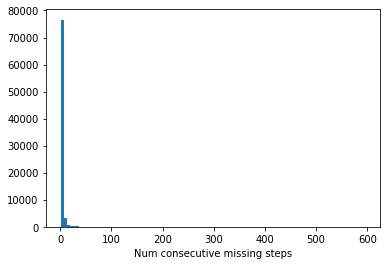

In [16]:
p = plt.hist(num_rows_added, bins=100)
plt.xlabel("Num consecutive missing steps")

In [17]:
len(num_rows_added)

81210

In [18]:
df_filled

Maßnahme,rel_time,AF_Vital,AF_Vital_max,AF_Vital_min,AF_Vital_std,ALT_Labor,AST_Labor,Albumin_Labor,Alk_Labor,Alpha Blocker_Med,...,syst_NBD_Vital,syst_NBD_Vital_max,syst_NBD_Vital_min,syst_NBD_Vital_std,syst_Vital,syst_Vital_max,syst_Vital_min,syst_Vital_std,DB,Pat_ID
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eICU,141800
1,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eICU,141800
2,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eICU,141800
3,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eICU,141800
4,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eICU,141800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936546,19905.0,23.0,23.0,23.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,166.0,166.0,166.0,0.0,MIMIC,99863_100749
2936547,19920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIMIC,99863_100749
2936548,19935.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIMIC,99863_100749
2936549,19950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIMIC,99863_100749


In [19]:
df_filled.to_csv(f"data/df_filled_{minutes}.csv", index=False)

In [20]:
#minutes = 60
#df_filled = pd.read_csv(f"data/df_filled_{minutes}.csv", index_col=0)

In [21]:
# remove feature that have N% missing spots in at least one database
threshold = 1 - (1 - 0.99) / (60 / minutes)  # make it such that it is 0.99 for 60 minutes and 0.999 for 5 minutes
max_nan_frac_over_dbs = df_filled.groupby("DB").apply(lambda db: db.isna().mean()).max().sort_values()
drop_cols = list(max_nan_frac_over_dbs[max_nan_frac_over_dbs > threshold].index)
df_drop_too_missing = df_filled.drop(columns=drop_cols)
print("Dropped: ", drop_cols, " - ", len(drop_cols))

Dropped:  ['Albumin_Labor', 'Barbiturat_Med', 'Alk_Labor', 'CK_Labor', 'Leukocyten_Labor', 'Erythrocyten_Labor', 'Troponin_Labor', 'CK-MB_Labor', 'Lymphocyten_Labor', 'Basophile_Labor', 'Monocyten_Labor', 'Eosinophile_Labor', 'Lipase_Labor', 'Neutrophile_Labor', 'Triglyceride_Labor', 'pankreasspez_Labor', 'TSH_Labor', 'LDH_Labor', 'FCOHb_BGA', 'Cholesterin_Labor', 'CRP_Labor', 'RASS_Vital', 'fT4_Labor', 'fT3_Labor', 'FiO2_BGA', 'Bili_BGA']  -  26


In [22]:
# fill med missing with 0
df_med_filled = df_drop_too_missing.copy()
med_col_names = [col for col in df_med_filled.columns if "_Med" in col]
df_med_filled[med_col_names] = df_med_filled[med_col_names].fillna(df_med_filled[med_col_names].min())

In [23]:
# get patient data such as gender etc
df_static = pd.read_csv("data/Datenbank_Pat_ID.csv")
df_static = df_static[["Pat_ID", "Alter", "Diagnose_txt", "Geschlecht", "Größe", "Gewicht"]]
df_static = df_static.rename(columns={"Diagnose_txt": "Diagnose"})
# one-hot encode
df_static = pd.get_dummies(df_static, columns=["Diagnose", "Geschlecht"])
df_static = df_static.drop(columns=["Geschlecht_Weiblich"])
df_static = df_static.rename(columns={"Geschlecht_Männlich": "Geschlecht"})
# drop nan Pat_ID
df_static = df_static.dropna(subset=["Pat_ID"])

In [24]:
# merge
df_med_filled["Pat_ID"] = df_med_filled["Pat_ID"].astype(int)
df_static["Pat_ID"] = df_static["Pat_ID"].astype(int)
df_large = pd.merge(df_med_filled, df_static, on="Pat_ID", how="left")

In [25]:
# one-hot-encode DB
df_large = pd.get_dummies(df_large, columns=["DB"])

In [26]:
path = f"data/df_final_{minutes}.csv"
df_large.to_csv(path, index=False)
print("Saved to: ", path)

Saved to:  data/df_final_15.csv


In [28]:
# remove correlated feats
threshold = 0.99
dataset = df_large.drop(columns=["ICP_Vital"])
targets = df_large["ICP_Vital"]

# remove target from this correlation table as we want to keep features that are highly correlated with the target
print("Cols before corr:", len(dataset.columns))
col_corr = set() # Set of all the names of deleted columns
corr_matrix = dataset.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
            colname = corr_matrix.columns[i] # getting the name of column
            col_corr.add(colname)
            if colname in dataset.columns:
                print("Deleting column with name, ", colname, " as it is too highly correlated (", corr_matrix.iloc[i, j], ") with ", corr_matrix.columns[j])
                del dataset[colname] # deleting the column from the dataset                
print("Cols after corr:", len(dataset.columns))
# check correlations with Vital_ICP value
dataset["ICP"] = list(targets)
corr_matrix = dataset.corr()
icp_cor = corr_matrix["ICP"].to_numpy()
thresh = 0.0001
too_small_corr_mask = np.abs(icp_cor) < thresh
drop_cols = ["ICP"] + list(np.array(corr_matrix.columns)[too_small_corr_mask])
drop_cols = [c for c in drop_cols if "DB_" not in c]
print("Dropping because of too small correlation with target: ", drop_cols)
dataset = dataset.drop(columns=drop_cols)   

df_decorrelated = pd.concat([dataset, targets], axis=0)

Cols before corr: 104
Deleting column with name,  FiO2_Vital_max  as it is too highly correlated ( 0.9982634558084503 ) with  FiO2_Vital
Deleting column with name,  FiO2_Vital_min  as it is too highly correlated ( 0.9984194314097605 ) with  FiO2_Vital
Deleting column with name,  HF_Vital_max  as it is too highly correlated ( 0.9923326402013464 ) with  HF_Vital
Deleting column with name,  HF_Vital_min  as it is too highly correlated ( 0.9934849845846903 ) with  HF_Vital
Deleting column with name,  Temp_Vital_max  as it is too highly correlated ( 0.9998982094375675 ) with  Temp_Vital
Deleting column with name,  Temp_Vital_min  as it is too highly correlated ( 0.9998487017560123 ) with  Temp_Vital
Deleting column with name,  diast_NBD_Vital_max  as it is too highly correlated ( 0.9924058311975353 ) with  diast_NBD_Vital
Deleting column with name,  diast_NBD_Vital_min  as it is too highly correlated ( 0.9931525737019447 ) with  diast_NBD_Vital
Deleting column with name,  mittl_NBD_Vital_ma

In [29]:
save_path = f"data/{minutes}_/yeo_N/normalization_None/median/uni_clip_0.9999/multi_clip_N/df.pkl"

In [39]:
import os
os.makedirs("/".join(save_path.split("/")[:-1]), exist_ok=True)
df_decorrelated.to_csv(save_path, index=False)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# check distributions
p = uke_df.hist(bins=100, figsize=(15, 15))
plt.tight_layout()

In [ ]:
from sklearn.preprocessing import PowerTransformer

transform = PowerTransformer(method='yeo-johnson', standardize=True)

In [ ]:
uke_df = df_large[df_large["DB_UKE"] == 1]

In [ ]:
uke_arr = uke_df.to_numpy()

In [ ]:
transform.fit(uke_arr)

In [ ]:
np.round(transform.lambdas_, 1)

In [ ]:
transformed_arr = transform.transform(uke_arr)

In [ ]:
lambdas_ = transform.lambdas_
mask = np.abs(lambdas_) > 5
print(lambdas_[mask])

In [ ]:
transformed_df = pd.DataFrame(transformed_arr, columns=df_large.columns)#, index=df_large.index)

In [ ]:
feat = "sO2_BGA"

In [ ]:
idx = list(transformed_df.columns).index(feat)
lambdas_[idx]

In [ ]:
uke_df[feat].describe()

In [ ]:
transformed_df[feat].describe()

In [ ]:
uke_df[feat].unique()

In [ ]:
transformed_df[feat].unique()

In [ ]:
uke_df[feat].hist(bins=100)

In [ ]:
transformed_df[feat].hist(bins=100)

In [ ]:
import numba
import numpy as np

@numba.jit()
def ema_fill(pat: np.ndarray, ema_val: float, mean: np.ndarray):
    # init ema
    ema = np.ones_like(pat[0]) * pat[0]
    ema[np.isnan(ema)] = mean[np.isnan(ema)]
    # run ema
    ema_steps = np.ones_like(pat)
    for i, pat_step in enumerate(pat):
        pat_step[np.isnan(pat_step)] = 0
        ema = ema_val * ema + (1 - ema_val) * pat_step
        ema_steps[i] = ema.copy()
    return ema_steps

In [ ]:
mean = uke_df.mean().to_numpy()

In [ ]:
uke_filled = uke_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, mean), columns=pat.columns))

In [ ]:
def four_parts(df):
    leng = len(df)
    first = df.iloc[0: leng // 4].mean()
    second = df.iloc[leng // 4: leng // 2].mean()
    third = df.iloc[leng // 2: leng * 3 // 4].mean()
    fourth = df.iloc[leng * 3 // 4:].mean()
    all_parts = [first, second, third, fourth]
    return pd.DataFrame(all_parts, columns=df.columns)

In [ ]:
umap_arr_red = umap_norm.reset_index(drop=True).groupby("Pat_ID").apply(four_parts).reset_index(drop=True).dropna()

In [ ]:
umap_arr_dropped = umap_arr_red.drop(columns=["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital"]).to_numpy()

In [ ]:
from sklearn.preprocessing import PowerTransformer

def apply_yeo(df, thresh=50, lambs=None):
    transform = PowerTransformer(method='yeo-johnson', standardize=False)
    drop_cols = ["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital", "rel_time"]
    dropped = df.drop(columns=drop_cols)
    arr = dropped.to_numpy()
    if lambs is None:
        # apply yeo
        transform.fit(arr)
        lambs = transform.lambdas_ 
        mask = np.abs(lambs) > thresh
        print(df["DB_MIMIC"].sum(), df["DB_UKE"].sum(), df["DB_eICU"].sum())
        print(mask.sum())
        #print(pd.Series(np.round(lambs, 1), index=dropped.columns).sort_values(np.abs(lambs)))
        print(np.round(lambs, 1))
        print()
        lambs[mask] = 1
    transform.lambdas_ = lambs
    trans_arr = transform.transform(arr)
    # merge back
    df = pd.concat([pd.DataFrame(trans_arr, columns=dropped.columns), df[drop_cols]], axis=1)
    return df, lambs

In [ ]:
def create_umap_df(df, yeo=False, lambs=None, mean=None, std=None, thresh=10):
    # apply yeo
    if yeo:
        df, _ = apply_yeo(df, lambs=lambs, thresh=thresh)
    # calc median
    median = df.median().to_numpy()
    # fill using ema
    df_filled = df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, median), columns=pat.columns)).reset_index(drop=True)
    # calc mean
    if mean is None:
        mean = df_filled.mean()
        std = df_filled.std()
        mean[std == 0] = 0
        std[std == 0] = 1
    #norm
    df_norm = (df_filled - mean) / std
    # average over four regions per Pat
    df_red = df_norm.groupby("Pat_ID").apply(four_parts).reset_index(drop=True).dropna()
    return df_red

In [ ]:
yeo = False
use_train_stats = False
thresh = 10

lambs = None
mean = None
std = None
    
if use_train_stats:
    train_df = df_large[df_large["DB_UKE"] == 1]
    if yeo:
        # calc lambdas for train dataset
        #train_df_filled = train_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.astype(float).sort_values("rel_time").to_numpy(), 0.9, train_df.median()), columns=pat.columns)).reset_index(drop=True)
        train_df, lambs = apply_yeo(train_df, thresh=thresh)
         # calc median
        median = train_df.median().to_numpy()
        # fill using ema
        train_df = train_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, median), columns=pat.columns)).reset_index(drop=True)
    
    # calc mean
    mean = train_df.mean().to_numpy()
    std = train_df.std()
    mean[std == 0] = 0
    std[std == 0] = 1


grouper = df_large["DB_UKE"] * 1 + df_large["DB_MIMIC"] * 2 + df_large["DB_eICU"] * 3
df_red = df_large.groupby(grouper).apply(lambda db: create_umap_df(db, yeo=yeo, lambs=lambs, mean=mean, std=std, thresh=thresh))
#df_red = transformed_df.groupby(grouper).apply(create_umap_df)

In [ ]:
if std is not None:
    std.sort_values()

In [ ]:
db_values = df_red["DB_UKE"] * 1 + df_red["DB_MIMIC"] * 2 + df_red["DB_eICU"] * 3
db_values[db_values == 1] = "UKE"
db_values[db_values == 2] = "MIMIC"
db_values[db_values == 3] = "eICU"

In [ ]:
# drop some cols and to numpy
drop_cols = ["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital"]
#drop_cols.extend([col for col in df_red.columns if "_Med" in col])
#drop_cols.extend([col for col in df_red.columns if "Diagnose" in col])
#drop_cols.extend([col for col in df_red.columns if "BGA" in col])
#drop_cols.extend([col for col in df_red.columns if "Labor" in col])
#drop_cols.extend([col for col in df_red.columns if "Vital" in col])

#print(drop_cols)
dropped = df_red.drop(columns=drop_cols)
#print(dropped.columns)
arr = dropped.to_numpy()

In [ ]:
df_used.groupby(grouper).apply(lambda db: db["Cl_BGA"].mean())

In [ ]:
df_used.groupby(grouper).apply(lambda db: db["Cl_BGA"].std())

In [ ]:
dropped.groupby(db_values).apply(lambda db: db["Cl_BGA"].std())

In [ ]:
dropped.groupby(db_values).apply(lambda db: db["Cl_BGA"].mean())

In [ ]:
dropped["Cl_BGA"].std()

In [ ]:
from umap import UMAP
import umap.plot

umapper = UMAP(n_components=2, n_neighbors=15)
umapped_arr = umapper.fit_transform(arr)

In [ ]:
from sklearn.decomposition import PCA
mapper = PCA()

pca_arr = mapper.fit_transform(arr)
pca_arr.shape

In [ ]:
colors = db_values.copy()
colors[colors=="UKE"] = "red"
colors[colors=="MIMIC"] = "blue"
colors[colors=="eICU"] = "green"

colors = df_red["DB_UKE"]
plt.figure(figsize=(15, 7))
plt.scatter(pca_arr[:, 0], pca_arr[:, 1], c=colors, s=1.5)

In [ ]:
plt.plot(mapper.explained_variance_)

In [ ]:
comp_idx = 0
plt.bar(range(len(mapper.components_[comp_idx])), mapper.components_[comp_idx])
print(mapper.components_[comp_idx].sum())

In [ ]:
max_comp_idx = np.argmax(mapper.components_[comp_idx])
print(max_comp_idx)
print(dropped.columns[max_comp_idx])

In [ ]:
dropped.groupby(db_values).apply(lambda x: x["Temp_Vital"].std())

In [ ]:
#help(UMAP)

In [ ]:
#umap.plot.points(umapper, theme="fire", values=df_red["Pupille re_Vital"])

In [ ]:
umap.plot.points(umapper, theme="fire", values=df_red["Phosphat_Labor"])

In [ ]:
# yeo all
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# yeo all
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# all
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# all yeo
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# only static
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# only vital
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# no med + no diag
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# no med
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
list(transformed_df.columns).index("Na_BGA")

In [ ]:
p = transformed_df.loc[:, mask].hist(figsize=(13, 13), bins=100)

In [ ]:
# find stds of 0
transformed_df.loc[:, transformed_df.std() == 0]

In [ ]:
transformed_df["sO2_BGA"].describe()

In [ ]:
np.quantile(transformed_df["sO2_BGA"].dropna(), 0.9999)

In [ ]:
np.quantile(df_large["sO2_BGA"].dropna(), 0.99)

In [ ]:
df_large["sO2_BGA"].describe()

In [ ]:
transformed_df.max()[transformed_df.max() > 5]

In [ ]:
transformed_df.loc[:, mask]

In [ ]:
transformed_df["Na_BGA"].hist(bins=100)
transformed_df["Na_BGA"].describe()

In [ ]:
p = transformed_df.hist(bins=100, figsize=(15, 15))
plt.tight_layout()

In [ ]:
(~df_large["ICP_Vital"].isna()).sum()

In [ ]:
(~df_large["ICP_Vital"].isna()).sum()

In [ ]:
len(df_large)

In [ ]:
(~df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

In [ ]:
len(df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"])

In [ ]:
# 5 min: 3093093 ICP_Vital non_nans. 154014 in MIMIC
# len total: xxx. MIMIC: 2118712

In [ ]:
# 60 min: 585353 ICP VItal non_nans in total. 128303 in MIMIC
# total steps: 735951. MIMIC: 177102

In [ ]:
test_df["Diagnose_Tumor"].isna().mean()

In [ ]:
test_df["Alter"].isna().mean()

In [ ]:
test_df = pd.read_csv("data/df_final_5.csv")

In [ ]:
len(test_df[test_df["DB_MIMIC"] == 1]["ICP_Vital"])

In [ ]:
(~test_df[test_df["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

In [ ]:
(~df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

In [ ]:
df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].hist(bins=100)

In [ ]:
pat_ids = []
for db in df_long["DB"].unique():
    subset = df_long[df_long["DB"] == db]
    ids = subset["Pat_ID"].unique()
    pat_ids.append(ids)

In [ ]:
id_dict = {}
for id_ in pat_ids[0]:
    id_dict[id_] = 1
    

In [ ]:
for id_ in pat_ids[1]:
    if id_ in id_dict:
        print(id_, "is duplicate!")
        id_dict[id_] = 1

In [ ]:
for id_ in pat_ids[2]:
    if id_ in id_dict:
        print(id_, "is duplicate!")
        id_dict[id_] = 1

In [ ]:
np.isinf(df_large.to_numpy()).sum()

In [ ]:
# check specific data
clinic = df_large[df_large["DB_UKE"] == 1]
pat_ids = clinic["Pat_ID"].unique()

In [ ]:
len(pat_ids)

In [ ]:
clinic["ICP_Vital"].isna().mean()

In [ ]:
pat_idx = -500

pat_id = pat_ids[pat_idx]
pat = clinic[clinic["Pat_ID"] == pat_id]

In [ ]:
pat.plot.scatter(x="rel_time", y="ICP_Vital")
pat.plot(x="rel_time", y="ICP_Vital")

In [ ]:
#pat["HF_Vital"].plot()

In [ ]:
uke = df_long[df_long["DB"] == "UKE"]

In [ ]:
uke[uke["Maßnahme_norm"] == "FiO2"]

In [ ]:
nan_frac_per_db = df_filled.groupby("DB").apply(lambda: db.isna().mean())

In [ ]:
nan_frac_per_db

In [ ]:
for col in df_filled.columns:
    nan_means = df_filled.groupby("DB").apply(lambda db: db[col].isna().mean())
    print(col)
    print(nan_means)
    print()
    if max(nan_means) > 0.99:
        print("Drop: ", col)

In [ ]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_BGA"].mean())

In [ ]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_Vital"].mean())

In [ ]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_Vital"].std())

In [ ]:
df_large["FiO2_BGA"]

In [ ]:
# FiO2 does not exist in UKE